<h1><center>Laboratorio 9: Optimizaci√≥n de modelos üíØ</center></h1>

<center><strong>MDS7202: Laboratorio de Programaci√≥n Cient√≠fica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesores: Ignacio Meza, Sebasti√°n Tinoco
- Auxiliares: Catherine Benavides y Consuelo Rojas
- Ayudante: Nicol√°s Ojeda, Eduardo Moya

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no ser√°n revisados

- Nombre de alumno 1: Manuel Zamorano
- Nombre de alumno 2: Javier Urrutia 


### Temas a tratar

- Predicci√≥n de demanda usando `xgboost`
- B√∫squeda del modelo √≥ptimo de clasificaci√≥n usando `optuna`
- Uso de pipelines.

### Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente ser√°n respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.
- C√≥digo que no se pueda ejecutar, no ser√° revisado.

### Objetivos principales del laboratorio

- Optimizar modelos usando `optuna`
- Recurrir a t√©cnicas de *prunning*
- Forzar el aprendizaje de relaciones entre variables mediante *constraints*
- Fijar un pipeline con un modelo base que luego se ir√° optimizando.

El laboratorio deber√° ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al m√°ximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante m√°s eficientes que los iteradores nativos sobre DataFrames.

### **Link de repositorio de GitHub:** `https://github.com/JUrrutia10/Laboratorios-MDS/tree/main/lab9`

# Importamos librerias √∫tiles

# El emprendimiento de Fiu

Tras liderar de manera exitosa la implementaci√≥n de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corp√≥reo **Fiu** se anima y decide levantar su propio negocio de consultor√≠a en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Como usted tuvo un rendimiento sobresaliente en el proyecto de caracterizaci√≥n de datos, Fiu lo contrata como *data scientist* de su emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset se√±alado y visualice a trav√©s de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempe√±o en el proyecto de caracterizaci√≥n de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('sales.csv')
df['date'] = pd.to_datetime(df['date'])

df.head()

C:\Users\jeus8\AppData\Local\Temp\ipykernel_15080\3184305967.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


id       date    city       lat      long     pop    shop        brand  \
0   0 2012-01-31  Athens  37.97945  23.71622  672130  shop_1  kinder-cola   
1   1 2012-01-31  Athens  37.97945  23.71622  672130  shop_1  kinder-cola   
2   2 2012-01-31  Athens  37.97945  23.71622  672130  shop_1  kinder-cola   
3   3 2012-01-31  Athens  37.97945  23.71622  672130  shop_1   adult-cola   
4   4 2012-01-31  Athens  37.97945  23.71622  672130  shop_1   adult-cola   

  container capacity  price  quantity  
0     glass    500ml   0.96     13280  
1   plastic    1.5lt   2.86      6727  
2       can    330ml   0.87      9848  
3     glass    500ml   1.00     20050  
4       can    330ml   0.39     25696

In [2]:
df.dtypes

id                    int64
date         datetime64[ns]
city                 object
lat                 float64
long                float64
pop                   int64
shop                 object
brand                object
container            object
capacity             object
price               float64
quantity              int64
dtype: object

## 1 Generando un Baseline (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su mag√≠ster en ciencia de datos y recuerda que debe seguir una serie de *buenas pr√°cticas* para entrenar correcta y debidamente su modelo. Despu√©s de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad.
2. Implemente un `FunctionTransformer` para extraer el d√≠a, mes y a√±o de la variable `date`. Guarde estas variables en el formato categorical de pandas.
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos num√©ricos y categ√≥ricos. Use `OneHotEncoder` para las variables categ√≥ricas.
4. Guarde los pasos anteriores en un `Pipeline`, dejando como √∫ltimo paso el regresor `DummyRegressor` para generar predicciones en base a promedios.
5. Entrene el pipeline anterior y reporte la m√©trica `mean_absolute_error` sobre los datos de validaci√≥n. ¬øC√≥mo se interpreta esta m√©trica para el contexto del negocio?
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los par√°metros por default**. ¬øC√≥mo cambia el MAE al implementar este algoritmo? ¬øEs mejor o peor que el `DummyRegressor`?
7. Guarde ambos modelos en un archivo .pkl (uno cada uno)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import joblib

In [4]:
# 1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad.

df['date'] = pd.to_datetime(df['date'])

# Dividir los datos en caracter√≠sticas (X) y variable objetivo (y)
X = df.drop(columns=['id', 'quantity']).copy()
y = df['quantity'].copy()

# Dividir en conjunto de entrenamiento (70%) y un conjunto temporal (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Dividir el conjunto temporal en validaci√≥n (20%) y prueba (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # 0.33 * 0.3 = 0.1

In [5]:
# 2. Implemente un FunctionTransformer para extraer el d√≠a, mes y a√±o de la variable date. Guarde estas variables en el formato categorical de pandas.

def extract_date_features(df):
    if isinstance(df, pd.DataFrame):
        df = df.copy()
        if 'date' in df.columns:
            df['year'] = df['date'].dt.year.astype('category')
            df['month'] = df['date'].dt.month.astype('category')
            df['day'] = df['date'].dt.day.astype('category')
            return df.drop(columns='date')
    return df

date_transformer = FunctionTransformer(extract_date_features)

In [6]:
# 3. Implemente un ColumnTransformer para procesar de manera adecuada los datos num√©ricos y categ√≥ricos. Use OneHotEncoder para las variables categ√≥ricas.

categorical_features = ['city', 'shop', 'brand', 'container', 'capacity', 'year', 'month', 'day']
numerical_features = ['lat', 'long', 'pop', 'price']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]#,remainder='passthrough'
)

In [7]:
# 4. Guarde los pasos anteriores en un Pipeline, dejando como √∫ltimo paso el regresor DummyRegressor para generar predicciones en base a promedios.

pipeline = Pipeline(steps=[
    ('date_transform', date_transformer),
    ('preprocessor', preprocessor),
    ('regressor', DummyRegressor(strategy='mean'))
])

In [8]:
# 5. Entrene el pipeline anterior y reporte la m√©trica mean_absolute_error sobre los datos de validaci√≥n. ¬øC√≥mo se interpreta esta m√©trica para el contexto del negocio?

# Entrenar pipeline
pipeline.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de validaci√≥n
y_val_pred = pipeline.predict(X_val)

# Calcular el mean absolute error (MAE)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Mean Absolute Error on validation set: {mae}')

Mean Absolute Error on validation set: 13308.134750658153


El MAE indica, en promedio, cu√°ntas unidades de la variable objetivo (cantidad vendida) difieren las predicciones del modelo de los valores reales. En este caso, el valor de 13308 significa que, en promedio, las predicciones del modelo tienen un error absoluto de aproximadamente 13308 unidades de cantidad vendida.

In [9]:
# 6. Finalmente, vuelva a entrenar el Pipeline pero esta vez usando XGBRegressor como modelo utilizando los par√°metros por default. ¬øC√≥mo cambia el MAE al implementar este algoritmo? ¬øEs mejor o peor que el DummyRegressor?

# Actualizar el pipeline con XGBRegressor
xgb_pipeline = Pipeline(steps=[
    ('date_transform', date_transformer),
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

# Entrenar el pipeline con XGBRegressor
xgb_pipeline.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de validaci√≥n con XGBRegressor
y_val_pred_xgb = xgb_pipeline.predict(X_val)

# Calcular el mean absolute error (MAE) para XGBRegressor
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
print(f'Mean Absolute Error on validation set with XGBRegressor: {mae_xgb}')

Mean Absolute Error on validation set with XGBRegressor: 2504.8566180688836


El MAE obtenido con el `XGBRegressor` es 2504.8566180688836, mientras que el MAE obtenido con el `DummyRegressor` fue 13308.134750658153. El `XGBRegressor` redujo significativamente el MAE en comparaci√≥n con el `DummyRegressor`, lo que indica que `XGBRegressor` es mucho m√°s efectivo para predecir la cantidad vendida. Este menor MAE sugiere que las predicciones del `XGBRegressor` est√°n, en promedio, mucho m√°s cerca de los valores reales de ventas.

In [10]:
# 7. Guarde ambos modelos en un archivo .pkl (uno cada uno)

# Guardar el modelo DummyRegressor
joblib.dump(pipeline, 'dummy_regressor_model.pkl')

# Guardar el modelo XGBRegressor
joblib.dump(xgb_pipeline, 'xgb_regressor_model.pkl')

['xgb_regressor_model.pkl']

## 2. Forzando relaciones entre par√°metros con XGBoost (1.0 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la econom√≠a le *sopla* que la demanda guarda una relaci√≥n inversa con el precio del producto. Motivado para impresionar al querido corp√≥reo, se propone hacer uso de esta informaci√≥n para mejorar su modelo realizando las siguientes tareas:

1. Vuelva a entrenar el `Pipeline`, pero esta vez forzando una relaci√≥n mon√≥tona negativa entre el precio y la cantidad. Para aplicar esta restricci√≥n ap√≥yese en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentaci√≥n</a>. Hint: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. De ser as√≠, probablemente le sea √∫til **mantener el formato de pandas** antes del step de entrenamiento.

2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validaci√≥n.

3. ¬øC√≥mo cambia el error al incluir esta relaci√≥n? ¬øTen√≠a raz√≥n su amigo?




In [11]:
def feat_names(x):
    # Crear el pipeline para obtener los nombres de las caracter√≠sticas despu√©s de la transformaci√≥n
    temp_pipeline = Pipeline(steps=[
        ('date_transform', date_transformer),
        ('preprocessor', preprocessor)
    ])

    # Ajustar el pipeline temporal
    temp_pipeline.fit(x)

    # Obtener los nombres de las caracter√≠sticas despu√©s de la transformaci√≥n
    feature_names = temp_pipeline.named_steps['preprocessor'].get_feature_names_out().copy()

    feature_names= [name.replace('cat__', '') for name in feature_names]
    feature_names= [name.replace('num__', '') for name in feature_names]
    return feature_names

In [12]:


# Crear el pipeline con XGBRegressor con una restricci√≥n mon√≥tona negativa en 'price'
xgb_pipeline = Pipeline(steps=[
    ('date_transform', date_transformer),
    ('preprocessor', preprocessor),
    ('to_dataframe', FunctionTransformer(func=lambda x: pd.DataFrame(x.todense(), columns=feat_names(X_train)))),
    ('model', XGBRegressor(monotone_constraints={'price': -1}))
])

# Entrenar el pipeline con la restricci√≥n mon√≥tona negativa
xgb_pipeline.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de validaci√≥n con el modelo actualizado
y_val_pred_xgb_constrained = xgb_pipeline.predict(X_val)

# Calcular el mean absolute error (MAE) para el modelo con la restricci√≥n mon√≥tona negativa
mae_xgb_constrained = mean_absolute_error(y_val, y_val_pred_xgb_constrained)
print(f'Mean Absolute Error on validation set with XGBRegressor (monotonic constraint): {mae_xgb_constrained}')

Mean Absolute Error on validation set with XGBRegressor (monotonic constraint): 2574.8494157574683


## 3. Optimizaci√≥n de Hiperpar√°metros con Optuna (2.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun m√°s* su modelo. En particular, le comenta de la optimizaci√≥n de hiperpar√°metros con metodolog√≠as bayesianas a trav√©s del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuraci√≥n obtenida en la secci√≥n anterior, utilice `optuna` para optimizar sus hiperpar√°metros. En particular, se le pide:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como m√©todo de muestreo
- De `XGBRegressor`, optimice los siguientes hiperpar√°metros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperpar√°metro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)
- Explique cada hiperpar√°metro y su rol en el modelo. ¬øHacen sentido los rangos de optimizaci√≥n indicados?
- Fije el tiempo de entrenamiento a 5 minutos
- Reportar el n√∫mero de *trials*, el `MAE` y los mejores hiperpar√°metros encontrados. ¬øC√≥mo cambian sus resultados con respecto a la secci√≥n anterior? ¬øA qu√© se puede deber esto?
- Guardar su modelo en un archivo .pkl

In [13]:
import optuna

In [133]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define la funci√≥n objetivo
def objective(trial):
    # Definir los hiperpar√°metros a ajustar
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }

    date_transformer = FunctionTransformer(extract_date_features)
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=trial.suggest_float('min_frequency', 0.0, 1.0)), categorical_features)
       ]
     )


    # Crear y entrenar el modelo XGBRegressor con los hiperpar√°metros dados
    model = XGBRegressor(**xgb_params, random_state=42)

    # Crear el pipeline
    pipeline = Pipeline(steps=[
        ('date_transform', date_transformer),
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Entrenar el pipeline con los datos de entrenamiento
    pipeline.fit(X_train, y_train)

    # Predecir sobre el conjunto de validaci√≥n y calcular el MAE
    y_pred = pipeline.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Ejecutar la optimizaci√≥n con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=300, show_progress_bar=True)

# Obtener el MAE y los mejores hiperpar√°metros encontrados
best_mae = study.best_value
best_params = study.best_params
num_trials = len(study.trials)
best_model=study.best_trial

print(f'N√∫mero de trials: {num_trials}')
print(f'MAE: {best_mae}')
print('Mejores hiperpar√°metros encontrados:')
for key, value in best_params.items():
    print(f'{key}: {value}')

TypeError: objective() takes 1 positional argument but 3 were given

In [130]:
best_model=study.best_trial


joblib.dump(best_model, 'mejor_modelo.pkl')

['mejor_modelo.pkl']

*  `learning_rate:` Es el tama√±o del paso en el proceso de ajuste. Un valor m√°s peque√±o hace que el modelo avance m√°s lentamente hacia la convergencia, lo que puede mejorar la precisi√≥n, pero tambi√©n aumentar el tiempo de entrenamiento. El rango sugerido de (0.001, 0.1) tiene sentido ya que estos valores son t√≠picos para el learning rate en modelos de gradient boosting.

* ` n_estimators:` Es el n√∫mero de √°rboles de decisi√≥n a construir. Un mayor n√∫mero de √°rboles puede mejorar la precisi√≥n del modelo, pero tambi√©n aumentar el tiempo de entrenamiento. El rango sugerido de (50, 1000) tiene sentido para explorar una amplia gama de posibles valores.

*  `max_depth:` Es la profundidad m√°xima de cada √°rbol de decisi√≥n. Un valor m√°s alto permite al modelo capturar relaciones m√°s complejas en los datos, pero tambi√©n puede llevar al sobreajuste. El rango sugerido de (3, 10) es t√≠pico para evitar sobreajustes y a√∫n as√≠ permitir cierta complejidad en el modelo.

*  `max_leaves`: Es el n√∫mero m√°ximo de hojas en cada √°rbol de decisi√≥n. Controla la complejidad del √°rbol. El rango sugerido de (0, 100) es amplio para explorar diferentes niveles de complejidad.

*  `min_child_weight:` Es la cantidad m√≠nima de instancias necesarias en cada nodo hoja. Ayuda a prevenir el sobreajuste. El rango sugerido de (1, 5) tiene sentido para evitar que los nodos hoja tengan muy pocas instancias.

*  `reg_alpha` y `reg_lambda`: Son t√©rminos de regularizaci√≥n que ayudan a controlar la complejidad del modelo y prevenir el sobreajuste. El rango sugerido de (0, 1) permite explorar diferentes niveles de regularizaci√≥n.

*  `min_frequency:` Es el hiperpar√°metro min_frequency del OneHotEncoder, que controla el n√∫mero m√≠nimo de veces que una categor√≠a debe aparecer en el conjunto de datos para ser considerada. Un valor m√°s alto puede reducir la dimensionalidad del conjunto de datos y mejorar la generalizaci√≥n del modelo.


El MAE obtenido en esta secci√≥n (1936.20) es menor que el MAE obtenido en la secci√≥n anterior (2504.86). Esto indica que el modelo entrenado con los hiperpar√°metros optimizados tiene un mejor rendimiento en la predicci√≥n de la demanda en comparaci√≥n con el modelo que no ten√≠a sus hiperpar√°metros ajustados.

Esto puede deberse a que el ajuste de los hiperpar√°metros permite al modelo adaptarse mejor a los datos y capturar las relaciones subyacentes entre las caracter√≠sticas y la variable objetivo. Espec√≠ficamente, los hiperpar√°metros como `learning_rate`, `n_estimators`, `max_depth`, `min_child_weight`, `reg_alpha`, `reg_lambda`, y `min_frequency` pueden influir significativamente en la capacidad del modelo para capturar la complejidad del problema y evitar el sobreajuste.

## 4. Optimizaci√≥n de Hiperpar√°metros con Optuna y Prunners (1.7)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Despu√©s de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en s√≠ mismo. Despu√©s de leer un par de post de personas de dudosa reputaci√≥n en la *deepweb*, usted llega a la conclusi√≥n que puede cumplir este objetivo mediante la implementaci√≥n de **Prunning**.

Vuelva a optimizar los mismos hiperpar√°metros que la secci√≥n pasada, pero esta vez utilizando **Prunning** en la optimizaci√≥n. En particular, usted debe:

- Responder: ¬øQu√© es prunning? ¬øDe qu√© forma deber√≠a impactar en el entrenamiento?
- Utilizar `optuna.integration.XGBoostPruningCallback` como m√©todo de **Prunning**
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos
- Reportar el n√∫mero de *trials*, el `MAE` y los mejores hiperpar√°metros encontrados. ¬øC√≥mo cambian sus resultados con respecto a la secci√≥n anterior? ¬øA qu√© se puede deber esto?
- Guardar su modelo en un archivo .pkl

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opci√≥n anterior, pueden especificar `show_progress_bar = True` en el m√©todo `optimize` para *m√°s sabor*.

Hint: Si quieren especificar par√°metros del m√©todo .fit() del modelo a trav√©s del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementaci√≥n

In [144]:
from optuna.integration import XGBoostPruningCallback

optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna.logging.disable_default_handler()
def get_feature_names(preprocessor):
        # Ajustar el preprocesador temporalmente para obtener los nombres de las caracter√≠sticas
        temp_pipeline = Pipeline(steps=[
            ('date_transform', date_transformer),
            ('preprocessor', preprocessor)
        ])

        temp_pipeline.fit(X_train)

        feature_names = temp_pipeline.named_steps['preprocessor'].get_feature_names_out().copy()
        feature_names = [name.replace('cat__', '') for name in feature_names]
        feature_names = [name.replace('num__', '') for name in feature_names]
        return feature_names
def todf(x):
    if isinstance(x, np.ndarray):
        df = pd.DataFrame(x, columns=get_feature_names(preprocessortri))
    else:
        df = pd.DataFrame(x.todense(), columns=get_feature_names(preprocessortri))
    return df
# Define la funci√≥n objetivo
def objective(trial):
    # Definir los hiperpar√°metros a ajustar
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
         
    }

    # Crear el modelo XGBRegressor con los hiperpar√°metros dados
    modelxgb = XGBRegressor(**xgb_params, random_state=42, enable_categorical=True, 
        eval_metric="mae", early_stopping_rounds=10,callbacks=[XGBoostPruningCallback(trial, "validation_0-mae")])

    date_transformer = FunctionTransformer(extract_date_features)
    global preprocessortri
    preprocessortri = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=trial.suggest_float('min_frequency', 0.0, 1.0)), categorical_features)
       ],remainder='passthrough'
     )
    


    pipelinexgb = Pipeline(steps=[
        ('date_transform', date_transformer),
        ('preprocessor', preprocessortri),
        ('to_dataframe', FunctionTransformer(func=todf)),
        ('regressor', modelxgb)
    ])
    

    
    
    X_train_tr=pipelinexgb[:-1].fit_transform(X_train)
    X_val_tr=pipelinexgb[:-1].transform(X_val)

    # Entrenar el pipeline con los datos de entrenamiento
    
    
    fitted=pipelinexgb[-1].fit(X_train_tr, y_train,eval_set=[(X_val_tr, y_val)])



    return fitted.best_score

# Ejecutar la optimizaci√≥n con Optuna
study2 = optuna.create_study(direction='minimize')
study2.optimize(objective, timeout=300, show_progress_bar=True)



   0%|          | 00:00/05:00

[0]	validation_0-mae:13261.54142
[1]	validation_0-mae:13215.28712
[2]	validation_0-mae:13170.82569
[3]	validation_0-mae:13126.17061
[4]	validation_0-mae:13083.29482
[5]	validation_0-mae:13039.88437
[6]	validation_0-mae:12998.49118
[7]	validation_0-mae:12956.14155
[8]	validation_0-mae:12915.49265
[9]	validation_0-mae:12873.91028
[10]	validation_0-mae:12834.30495
[11]	validation_0-mae:12794.91550
[12]	validation_0-mae:12755.41872
[13]	validation_0-mae:12715.69227
[14]	validation_0-mae:12676.97104
[15]	validation_0-mae:12637.79749
[16]	validation_0-mae:12599.71104
[17]	validation_0-mae:12561.33019
[18]	validation_0-mae:12523.20210
[19]	validation_0-mae:12486.24005
[20]	validation_0-mae:12449.02748
[21]	validation_0-mae:12412.91750
[22]	validation_0-mae:12376.74293
[23]	validation_0-mae:12341.69808
[24]	validation_0-mae:12306.13092
[25]	validation_0-mae:12271.78704
[26]	validation_0-mae:12238.05402
[27]	validation_0-mae:12204.61585
[28]	validation_0-mae:12170.89529
[29]	validation_0-mae:12

In [145]:
# Obtener el MAE y los mejores hiperpar√°metros encontrados
best_mae2 = study2.best_value
best_params2 = study2.best_params
num_trials2 = len(study2.trials)

print(f'N√∫mero de trials: {num_trials2}')
print(f'MAE: {best_mae2}')
print('Mejores hiperpar√°metros encontrados:')
for key, value in best_params2.items():
    print(f'{key}: {value}')

N√∫mero de trials: 146
MAE: 1977.3430340388747
Mejores hiperpar√°metros encontrados:
learning_rate: 0.0888616337968059
n_estimators: 676
max_depth: 8
max_leaves: 77
min_child_weight: 5
reg_alpha: 0.5944329069656108
reg_lambda: 0.20385536570632837
min_frequency: 0.001186848304714076


In [146]:
# Guardar el mejor modelo en un archivo .pkl
best_model_callback = study2.best_trial

joblib.dump(best_model_callback, 'mejor_modelo_callback.pkl')

['mejor_modelo_callback.pkl']


El pruning es una t√©cnica utilizada en el entrenamiento de modelos de aprendizaje autom√°tico para evitar el sobreajuste y acelerar el proceso de optimizaci√≥n. Consiste en detener el entrenamiento de un modelo cuando no se observa una mejora significativa en una m√©trica de evaluaci√≥n durante un cierto n√∫mero de iteraciones consecutivas.

Cuando se utiliza pruning en la optimizaci√≥n de hiperpar√°metros con Optuna, se eval√∫a la m√©trica de inter√©s en cada iteraci√≥n del entrenamiento y se detiene prematuramente cualquier ensayo que no muestre una mejora significativa en la m√©trica de evaluaci√≥n, seg√∫n ciertos criterios de parada definidos.

En los resultados se ve que se tiene un MAE un poco mayor para este modelo cerca de 50 puntos mas, tiene sentido ya que se evita el sobre ajuste del modelo, es probable que en el test, este modelo tenga mejor resultado que el anterior comparando metricas de training con test.

## 5. Visualizaciones (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

1. Gr√°fico de historial de optimizaci√≥n
2. Gr√°fico de coordenadas paralelas
3. Gr√°fico de importancia de hiperpar√°metros

Comente sus resultados:

4. ¬øDesde qu√© *trial* se empiezan a observar mejoras notables en sus resultados?
5. ¬øQu√© tendencias puede observar a partir del gr√°fico de coordenadas paralelas?
6. ¬øCu√°les son los hiperpar√°metros con mayor importancia para la optimizaci√≥n de su modelo?

In [147]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

In [155]:
plot_optimization_history(study2)


segun el grafico desde el el trial 26 baja bastante el valor del mae, se estabiliza casi en el minimo en el trial 44

In [149]:
plot_parallel_coordinate(study2)


a partir de este grafico se puede notar que los trials con valores objetivos(MAE) mas bajos tienden a tener el maximo learning rate posible, entre 4-5 min_child_weight, el min_frequency muy bajo, los otros hiper parametros varian harto.

In [150]:
plot_param_importances(study2)

claramente el hiperparametro con mayor importancia es min_frequency y con gran diferencia con los otros, esto es debido que este hiper parametro es el que determina las variables que pasan por el onehotencoder, por lo que afecta en gran medida el modelo, ya que puede disminuir bastante el numero de columnas del dataframe.

## 6. S√≠ntesis de resultados (0.3)

Finalmente:

1. Genere una tabla resumen del MAE obtenido en los 5 modelos entrenados desde Baseline hasta XGBoost con Constraints, Optuna y Prunning.
2. Compare los resultados de la tabla y responda, ¬øqu√© modelo obtiene el mejor rendimiento?
3. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE.
4. ¬øExisten diferencias con respecto a las m√©tricas obtenidas en el conjunto de validaci√≥n? ¬øPorqu√© puede ocurrir esto?

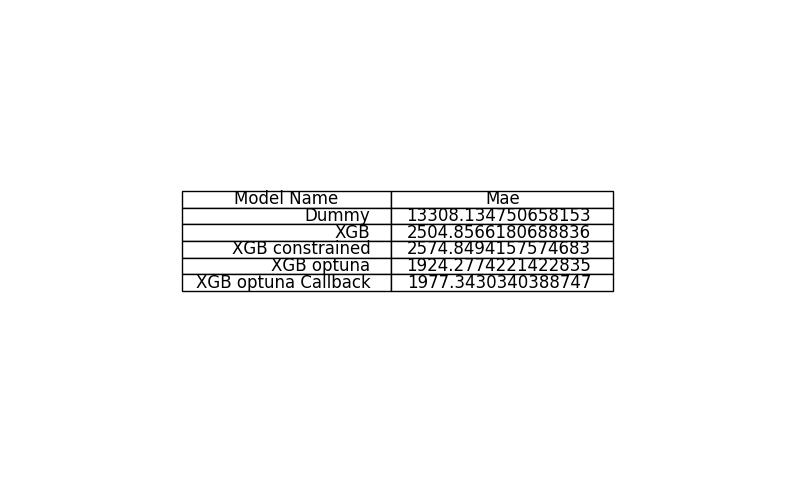

In [156]:
import matplotlib.pyplot as plt
metric_names = ['Model Name', 'Mae']
metric_values = [
    ['Dummy', mae],
    ['XGB', mae_xgb],
    ['XGB constrained', mae_xgb_constrained],
    ['XGB optuna', best_mae],
    ['XGB optuna Callback', best_mae2]
]

# Crear una figura y un eje
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Ocultar los ejes
ax.axis('off')

# Crear una tabla
table2 = ax.table(cellText=metric_values, colLabels=metric_names, loc='center')

# Ajustar el tama√±o de la fuente en la tabla
table2.auto_set_font_size(False)
table2.set_fontsize(12)

# Ajustar el ancho de las columnas
table2.auto_set_column_width(col=list(range(len(metric_names))))

# Mostrar la tabla
plt.show()

solo por el valor del Mae de la data de validacion se puede concluir que el cuarto modelo, el primero con optuna es el mejor aunque la diferencia es bastante baja con el ultimo.

In [157]:
def objectiveX(trial,X,Y):
    # Definir los hiperpar√°metros a ajustar
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }

    date_transformer = FunctionTransformer(extract_date_features)
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=trial.suggest_float('min_frequency', 0.0, 1.0)), categorical_features)
       ]
     )


    # Crear y entrenar el modelo XGBRegressor con los hiperpar√°metros dados
    model = XGBRegressor(**xgb_params, random_state=42)

    # Crear el pipeline
    pipeline = Pipeline(steps=[
        ('date_transform', date_transformer),
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Entrenar el pipeline con los datos de entrenamiento
    pipeline.fit(X_train, y_train)

    # Predecir sobre el conjunto de validaci√≥n y calcular el MAE
    y_pred = pipeline.predict(X)
    mae = mean_absolute_error(Y, y_pred)

    return mae

In [158]:


modelopkl = joblib.load("mejor_modelo.pkl")

maetest=objectiveX(modelopkl,X_test,y_test)
print(f'Mean Absolute Error en test set Modelo optuna : {maetest}')


Mean Absolute Error en test set Modelo optuna : 1956.436683665109


como se puede notar para el mejor modelo hay una diferencia en el valor del mae del conjunto de validacion con el conjunto de test, pero es muy peque√±a, solo de 32, que para este caso seria incluso menor a la diferencia que tenia con los otros modelos.



# Conclusi√≥n
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://media.tenor.com/8CT1AXElF_cAAAAC/gojo-satoru.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>